In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder.appName("CleanedData").getOrCreate()

# Path to the CSV file
file_path = "/content/drive/My Drive/cleaned.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


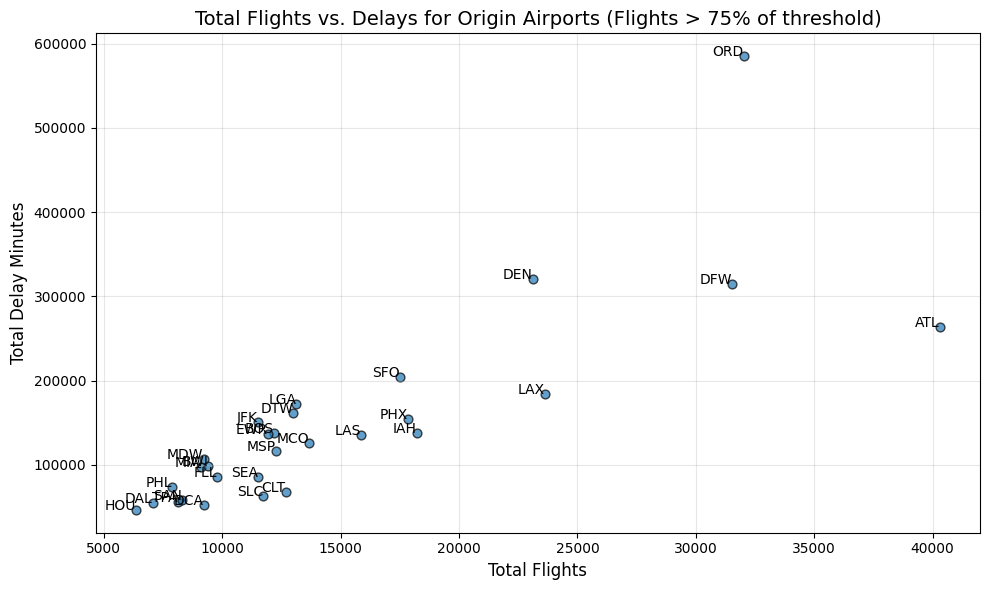

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
import statistics

# Aggregating flight counts and delays for origin airports
airport_flight_counts = defaultdict(int)  # {airport: total_flights}
airport_total_delays = defaultdict(float)  # {airport: total_delay_minutes}

# Reading and processing the CSV file
with open(file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        try:
            delay = float(row['DEPARTURE_DELAY']) if row['DEPARTURE_DELAY'] else 0
        except ValueError:
            delay = 0

        airport = row['ORIGIN_AIRPORT']
        airport_flight_counts[airport] += 1  # Count each flight for the airport
        airport_total_delays[airport] += delay  # Sum up delay minutes for the airport

# Calculate mean number of flights
route_counts = [count for _, count in airport_flight_counts.items()]
filtered_counts = [count for count in route_counts if count > statistics.median(route_counts)]  # Normalize by excluding values below the median
mean_value = sum(filtered_counts) / len(filtered_counts)
threshold = 1.5 * mean_value

# Preparing data for the scatter plot
x_flights = []  # Total flights
y_delays = []  # Total delay minutes
labels = []  # Airport short names for labeling points

for airport, total_flights in airport_flight_counts.items():
    if total_flights > threshold:  # Apply the threshold of 30% of the mean
        x_flights.append(total_flights)
        y_delays.append(airport_total_delays[airport])
        labels.append(airport)  # Use short name from airport_map

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_flights, y_delays, alpha=0.7, edgecolor='k', s=40)

# Adding labels to points (optional, for clarity)
for i, label in enumerate(labels):
    plt.text(x_flights[i], y_delays[i], label, fontsize=10, ha='right')

# Adding titles and labels
plt.title("Total Flights vs. Delays for Origin Airports (Flights > 75% of threshold)", fontsize=14)
plt.xlabel("Total Flights", fontsize=12)
plt.ylabel("Total Delay Minutes", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


1. Correlation Between Traffic and Delays : Airports with a higher number of total flights tend to have more total delay minutes. This indicates a positive correlation between air traffic and delays, which is expected due to higher congestion levels.
2. Outliers in Delay Performance : Some airports, such as ORD (Chicago O'Hare), have disproportionate delays compared to airports like DFW or ATL which handles more number of flights.
3. Small Airports with High Delays : Some smaller airports (towards the lower left of the chart) show disproportionately high delays despite having fewer flights. This could be due to regional weather patterns, limited infrastructure, or airline-specific issues.

To better understand airport efficiency, we need to consider average delays and standard deviation. Average delay per flight gives a clearer picture of delays independent of flight volume, while standard deviation highlights the variability of delays. For example, an airport with a low average delay but high variability may still be unreliable, while one with consistent delays (low SD) is more predictable.

By analyzing all three metrics—total delays, average delays, and standard deviation—we can identify airports that face systemic issues, have consistent underperformance, or suffer from unpredictable delays.

Airport with the Most Delays: ORD


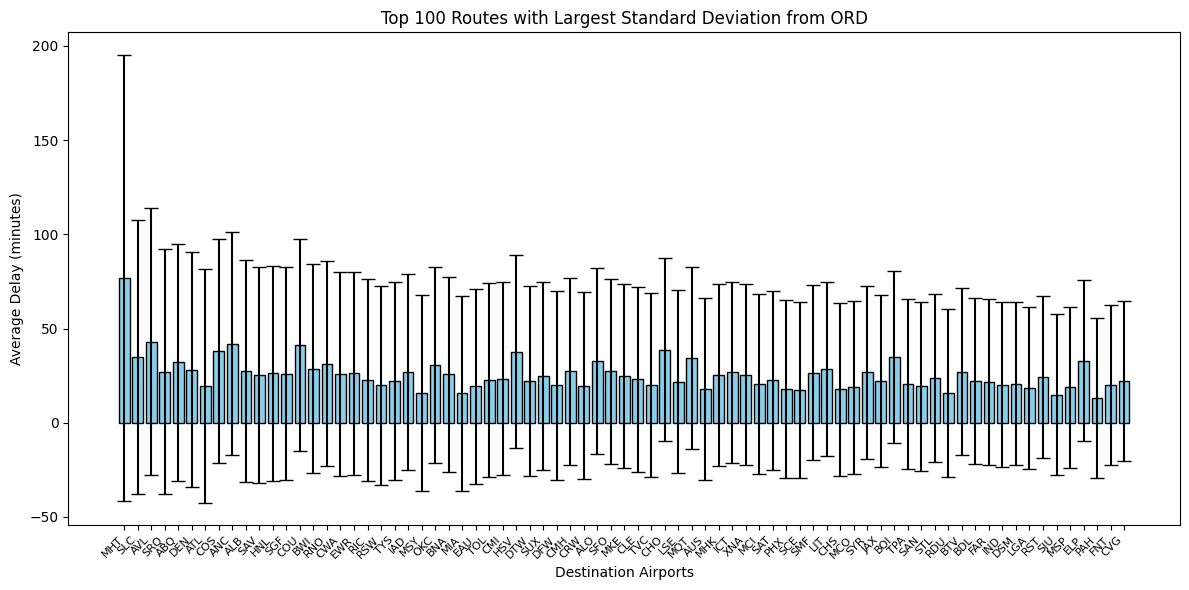


Delays for Other Origin Airports:
Origin Airport  Total Delay Minutes  Average Delay   Standard Deviation  
ANC             2216.00              1.40            26.40               
LAX             184223.00            7.93            30.99               
SFO             204430.00            12.04           40.96               
SEA             85582.00             7.49            30.93               
LAS             135585.00            8.63            36.99               
DEN             320300.00            14.06           35.22               
SLC             62768.00             5.38            31.61               
PDX             22787.00             4.63            31.49               
FAI             -151.00              -0.71           28.22               
MSP             116401.00            9.62            37.64               
PHX             154731.00            8.75            33.27               
SJU             33065.00             10.84           43.28               
PBG

In [ ]:
import csv
import matplotlib.pyplot as plt
from collections import defaultdict
from statistics import mean, stdev

# Step 1: Aggregate delay minutes for all origin airports
airport_delays = defaultdict(list)  # {origin_airport: [list of delays]}

with open(file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        try:
            delay = float(row['DEPARTURE_DELAY']) if row['DEPARTURE_DELAY'] else None
        except ValueError:
            delay = None
        if delay is not None:
            origin_airport = row['ORIGIN_AIRPORT']
            airport_delays[origin_airport].append(delay)

# Find the airport with the most total delay minutes
most_delayed_airport = max(airport_delays, key=lambda x: sum(airport_delays[x]))
print(f"Airport with the Most Delays: {most_delayed_airport}")

# Step 2: Calculate SD for routes from the most delayed airport
route_delays = defaultdict(lambda: defaultdict(list))  # {destination: {airline: [delays]}}

with open(file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        try:
            delay = float(row['DEPARTURE_DELAY']) if row['DEPARTURE_DELAY'] else None
        except ValueError:
            continue
        if delay is not None and row['ORIGIN_AIRPORT'] == most_delayed_airport:
            destination = row['DESTINATION_AIRPORT']
            airline = row['AIRL']
            route_delays[destination][airline].append(delay)

# Prepare data for plotting
destinations = []
avg_delays = []
std_devs = []

for dest, airline_delays in route_delays.items():
    combined_delays = []
    for delays in airline_delays.values():
        combined_delays.extend(delays)
    if len(combined_delays) > 1:  # Ensure sufficient data
        destinations.append(dest)
        avg_delays.append(mean(combined_delays))
        std_devs.append(stdev(combined_delays))

# Sort the routes by standard deviation in descending order and take the top 100
sorted_data = sorted(zip(destinations, avg_delays, std_devs), key=lambda x: x[2], reverse=True)[:75]

# Unpack the top 100 data with largest standard deviations
top_destinations, top_avg_delays, top_std_devs = zip(*sorted_data)

# Plot the graph for top 100 routes with the largest standard deviation
plt.figure(figsize=(12, 6))
plt.bar(top_destinations, top_avg_delays, yerr=top_std_devs, capsize=5, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel("Destination Airports")
plt.ylabel("Average Delay (minutes)")
plt.title(f"Top 100 Routes with Largest Standard Deviation from {most_delayed_airport}")
plt.tight_layout()
plt.show()



# Step 4: Table for remaining airports
print(f"\nDelays for Other Origin Airports:")
print(f"{'Origin Airport':<15} {'Total Delay Minutes':<20} {'Average Delay':<15} {'Standard Deviation':<20}")

count=0
for airport, delays in airport_delays.items():
    if airport != most_delayed_airport and count<=20:
        total_delay = sum(delays)
        avg_delay = mean(delays)
        sd_delay = stdev(delays) if len(delays) > 1 else 0
        print(f"{airport:<15} {total_delay:<20.2f} {avg_delay:<15.2f} {sd_delay:<20.2f}")
        count+=1

We get to see that ORD (O'Hare International Airport) has the most total delay minutes. This means that the sum of all recorded delay times for flights departing from ORD is the highest.

This metric focuses on the overall delay burden at the airport. But in the previous graph we also get to see that ORD does hold highter flight volumes which eventually increases the overall delay time. Hence we have to arrive onto a metric which is more concrete that overlooks the fact of sum of delays from an origin airport. This means the "sum of delays" alone is not a fair indicator of an airport's efficiency or reliability.

A more concrete metric would consider average delays per flight and delay variability (standard deviation), which can better identify airports with both consistently poor performance and unpredictability. This would provide a more balanced evaluation, removing the bias caused by flight volumes.


From the table, airports like DEN and SFO face high total delays and average delays, likely due to large flight volumes and congestion. However, airports such as SJU and SFO show high standard deviations, indicating greater unpredictability in delays. In contrast, FAI reports negative average delays (earlier departures) but with moderate variability.

To evaluate airport performance effectively, considering both average delay and standard deviation is crucial, as total delays alone are often influenced by flight volume and do not fully reflect operational reliability.








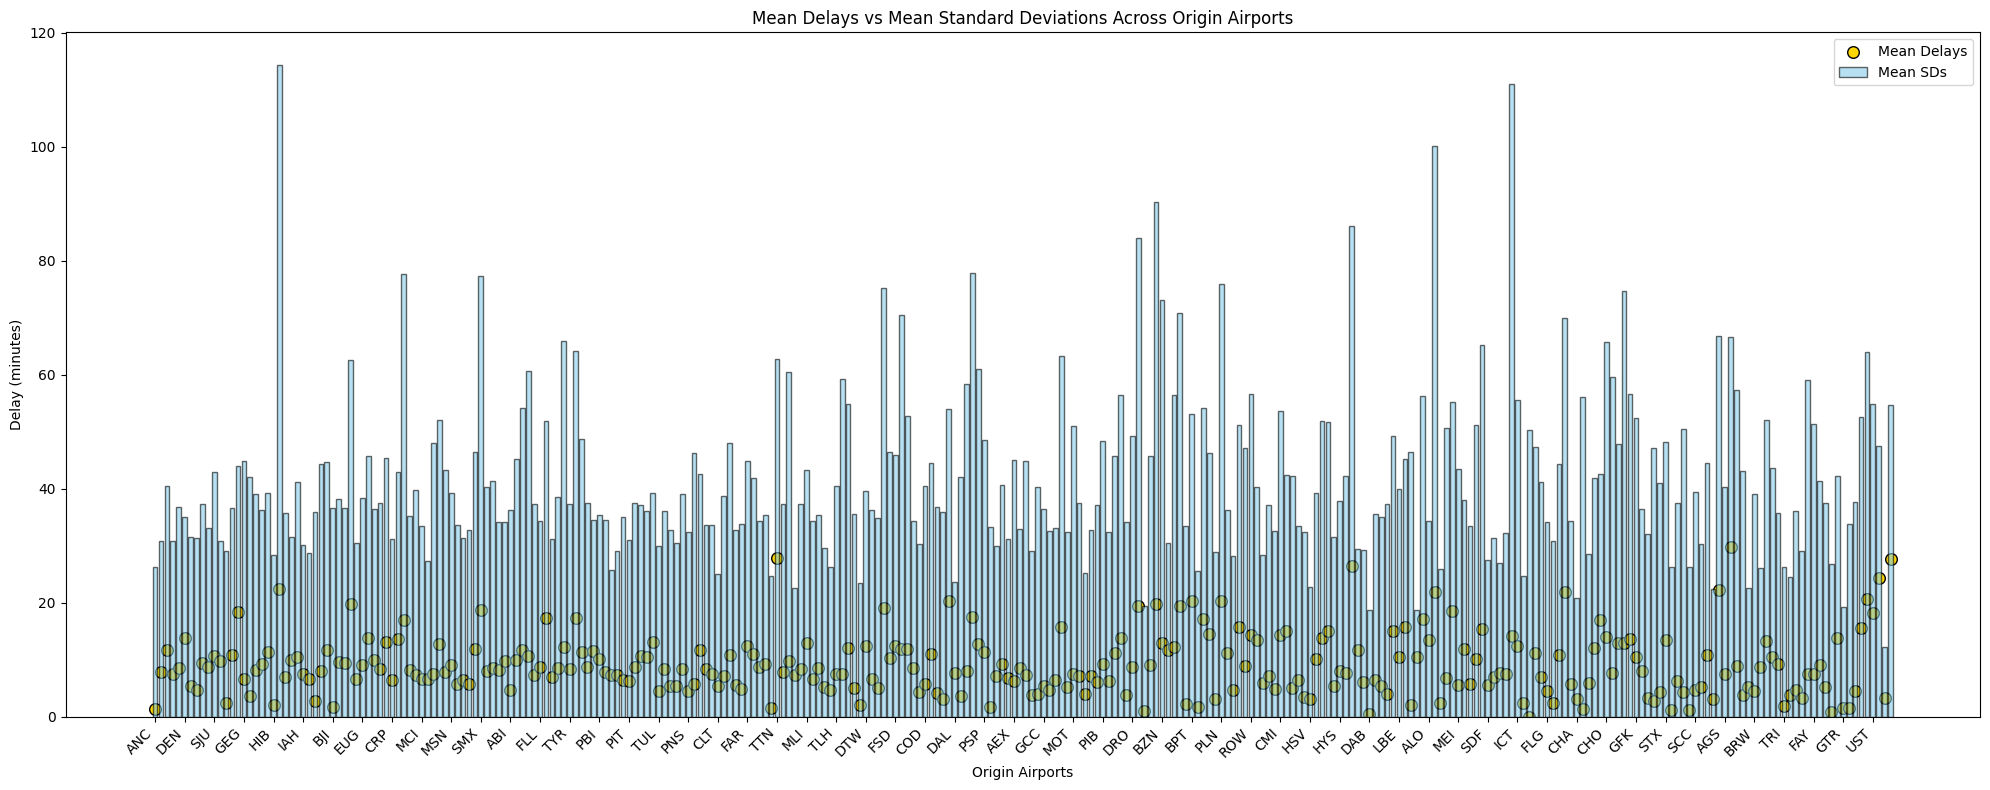


Mean Delays and Mean Standard Deviations:
+-----------+------------------------+---------------------+
| Airport   |   Mean Delay (minutes) |   Mean SD (minutes) |
+===========+========================+=====================+
| ANC       |                   1.39 |               26.27 |
+-----------+------------------------+---------------------+
| LAX       |                   7.8  |               30.75 |
+-----------+------------------------+---------------------+
| SFO       |                  11.68 |               40.4  |
+-----------+------------------------+---------------------+
| SEA       |                   7.43 |               30.82 |
+-----------+------------------------+---------------------+
| LAS       |                   8.55 |               36.83 |
+-----------+------------------------+---------------------+
| DEN       |                  13.86 |               35    |
+-----------+------------------------+---------------------+
| SLC       |                   5.35 |    

In [ ]:
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from statistics import mean, stdev
from tabulate import tabulate  # For clean table output

# Step 1: Read delay data for origin airports
airport_delays = defaultdict(list)

with open(file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        try:
            delay = float(row['DEPARTURE_DELAY']) if row['DEPARTURE_DELAY'] else 0
        except ValueError:
            delay = 0
        origin_airport = row['ORIGIN_AIRPORT']
        airport_delays[origin_airport].append(delay)

# Step 2: Calculate mean delays and mean standard deviations for each airport
filtered_airports = []
filtered_mean_delays = []
filtered_mean_sds = []

for airport, delays in airport_delays.items():
    if len(delays) > 1:  # Ensure enough data to calculate SD
        mean_delay = mean(delays)
        if mean_delay >= 0:  # Include only mean delays >= 0
            filtered_airports.append(airport)
            filtered_mean_delays.append(mean_delay)
            filtered_mean_sds.append(stdev(delays))

# Step 3: Plot mean delays as scatter points and mean SDs as bars
plt.figure(figsize=(20, 8))

# Scatter plot for mean delays
plt.scatter(range(len(filtered_airports)), filtered_mean_delays, color='gold', edgecolor='black', s=70, label="Mean Delays")

# Bar plot for mean standard deviations
plt.bar(range(len(filtered_airports)), filtered_mean_sds, color='skyblue', edgecolor='black', alpha=0.6, label="Mean SDs")

# Step 4: Add labels and format the x-axis
plt.xticks(range(0, len(filtered_airports), 5), filtered_airports[::5], rotation=45, ha='right')
plt.xlabel("Origin Airports")
plt.ylabel("Delay (minutes)")
plt.title("Mean Delays vs Mean Standard Deviations Across Origin Airports")
plt.legend()
plt.tight_layout()
plt.show()

# Step 5: Display tabular results for mean delays and mean SDs
table_data = [
    [airport, round(mean_delay, 2), round(mean_sd, 2)]
    for airport, mean_delay, mean_sd in zip(filtered_airports, filtered_mean_delays, filtered_mean_sds)
]

print("\nMean Delays and Mean Standard Deviations:")
print(tabulate(table_data[:20], headers=["Airport", "Mean Delay (minutes)", "Mean SD (minutes)"], tablefmt="grid"))



The graph compares mean delays and mean standard deviations across various origin airports. While mean delays indicate the average delay per airport, the mean SD highlights the variability in delays. Airports with high mean SDs show inconsistent performance, with delays varying significantly from flight to flight. Notably, airports with low mean delays can still exhibit large deviations, meaning delays are unpredictable despite lower averages.

Conclusion
Analyzing both mean delays and SDs provides deeper insights into airport performance. Airports with high mean SDs, even if their mean delays are moderate, indicate inconsistent operations, making them less reliable for on-time departures. Balancing both metrics is essential for understanding airport efficiency.